In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Activation, Dropout, Dense, Input, Concatenate, Embedding
from keras.layers import Flatten, BatchNormalization, Dot 
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten
from keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint 

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("ml-25m/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
df.shape

(25000095, 4)

In [4]:
df.isnull().values.any()

False

In [5]:
#check dup
bol_dup = df.duplicated(subset=['userId','movieId'], keep ='last') 
sum(bol_dup)

0

In [5]:
df = df[df['timestamp'] >= 1104512400] # Year 2005-2019
df.shape

(16074718, 4)

<AxesSubplot:xlabel='rating', ylabel='count'>

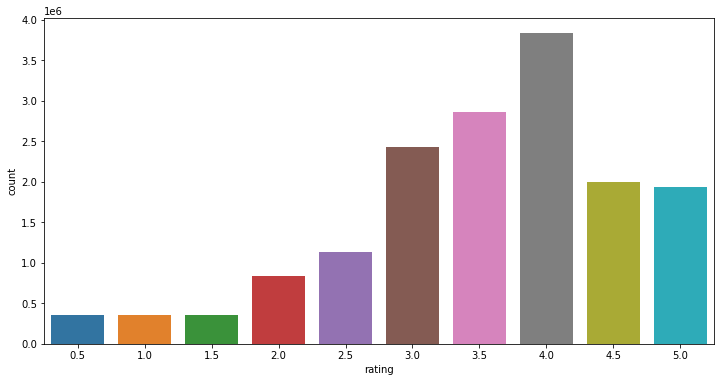

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='rating', data=df)

In [7]:
# Get number of users and number of movie
N = df['userId'].nunique()
M = df['movieId'].nunique()
print(f'N:{N}, M:{M}')

N:94745, M:59034


In [8]:
print(df['userId'].max())
print(df['movieId'].max())

162541
209171


In [9]:
df['userId'] = pd.Categorical(df['userId'])
df['new_user_id'] = df['userId'].cat.codes

df['movieId'] = pd.Categorical(df['movieId'])
df['new_movie_id'] = df['movieId'].cat.codes

In [10]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,296,5.0,1147880044,0,292
1,1,306,3.5,1147868817,0,302
2,1,307,5.0,1147868828,0,303
3,1,665,5.0,1147878820,0,652
4,1,899,3.5,1147868510,0,873


In [11]:
print(df['new_user_id'].max())
print(df['new_movie_id'].max())

94744
59033


In [12]:
map_user_id = df[["userId", "new_user_id"]].drop_duplicates(subset=['userId', 'new_user_id']).sort_values("userId")
map_movie_id = df[["movieId", "new_movie_id"]].drop_duplicates(subset=['movieId', 'new_movie_id']).sort_values("movieId")
map_user_id.to_csv('data/map_user_id.csv',index=False)
map_movie_id.to_csv('data/map_movie_id.csv',index=False)

In [13]:
map_movie_id.tail()

,movieId,new_movie_id
18457961,209157,59029
17864443,209159,59030
1036618,209163,59031
18457962,209169,59032
18457963,209171,59033


In [24]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state = 25)

In [25]:
train_set.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
89508,679,1527,2.5,1247880773,377,1468
19257122,124952,8874,4.0,1394414292,72863,8146
4638283,30329,1228,5.0,1407940633,17795,1190
17488381,113307,88125,4.0,1467573018,66202,16683
17429681,112925,115617,3.5,1556172930,65979,22368


In [26]:
print(f"Unique user in train: {train_set['userId'].nunique()}")
print(f"Unique movie in train: {train_set['movieId'].nunique()}")
print(f"Unique user in test: {test_set['userId'].nunique()}")
print(f"Unique movie in test: {test_set['movieId'].nunique()}")

Unique user in train: 94727
Unique movie in train: 56665
Unique user in test: 94378
Unique movie in test: 39420


In [31]:
print(f"Number of user in test only: {len(set(test_set['userId'].unique()) - set(train_set['userId'].unique()))}")

Number of user in test only: 18


In [29]:
print(f"Number of movie in test only: {len(set(test_set['movieId'].unique()) - set(train_set['movieId'].unique()))}")

Number of movie in test only: 2369


In [51]:
# Set embedding dimension
K = 100

In [57]:
# Make a neural network

# User input
u = Input(shape=(1,))
u_emb = Embedding(N, K)(u) 
u_vec = Flatten()(u_emb)


# Movie input
m = Input(shape=(1,))
m_emb = Embedding(M, K)(m) 
m_vec = Flatten()(m_emb)


# Concatenate or Dot user-movie embeddings
x = Concatenate()([u_vec, m_vec])
# x = Dot(normalize = True, axes=2)([u_vec, m_vec])

# regular NN
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='relu')(x)

In [58]:
u_model = Model(u, outputs=u_vec)
m_model = Model(m, outputs=m_vec)
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mae',
    optimizer='adam'
    #optimizer=SGD(lr=0.08, momentum=0.9)
)

In [59]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       9474500     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       5903400     input_8[0][0]                    
___________________________________________________________________________________________

In [60]:
checkpoint = ModelCheckpoint('model/movie_rec.hdf5', save_best_only=True, monitor="val_loss", mode='min', save_weights_only=False)  

In [61]:
hist = model.fit(
    x = [train_set.new_user_id, train_set.new_movie_id],
    y = train_set.rating,
    epochs = 10,
    batch_size = 1024,
    validation_data = ([test_set.new_user_id, test_set.new_movie_id], test_set.rating),
    callbacks = [checkpoint]
)

Epoch 1/10
12559/12559 [==============================] - 1100s 87ms/step - loss: 0.8068 - val_loss: 0.6133
Epoch 2/10
12559/12559 [==============================] - 1090s 87ms/step - loss: 0.6073 - val_loss: 0.5952
Epoch 3/10
12559/12559 [==============================] - 1060s 84ms/step - loss: 0.5745 - val_loss: 0.5707
Epoch 4/10
12559/12559 [==============================] - 1026s 82ms/step - loss: 0.5459 - val_loss: 0.5611
Epoch 5/10
12559/12559 [==============================] - 1033s 82ms/step - loss: 0.5274 - val_loss: 0.5550
Epoch 6/10
12559/12559 [==============================] - 1068s 85ms/step - loss: 0.5132 - val_loss: 0.5525
Epoch 7/10
12559/12559 [==============================] - 1066s 85ms/step - loss: 0.5005 - val_loss: 0.5513
Epoch 8/10
12559/12559 [==============================] - 1034s 82ms/step - loss: 0.4894 - val_loss: 0.5488
Epoch 9/10
12559/12559 [==============================] - 1024s 82ms/step - loss: 0.4795 - val_loss: 0.5499
Epoch 10/10
12559/12559 [===

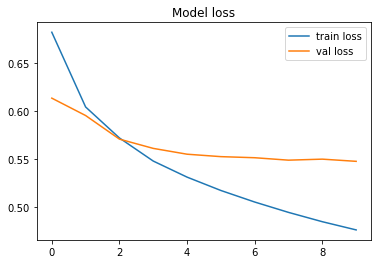

In [62]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.legend()
plt.show()

In [63]:
u_model.save('model/user_emb_model.h5')
m_model.save('model/movie_emb_model.h5')

In [64]:
# Evaluate the model from the last epoch
score = model.evaluate(x = [test_set.new_user_id, test_set.new_movie_id], y = test_set.rating , verbose=0 )
print( f"Test results (model from the last epoch): Loss {score}" )

# Load and evaluate the model from the best epoch
best_model = load_model('model/movie_rec.hdf5', compile=True )
score = best_model.evaluate(x = [test_set.new_user_id, test_set.new_movie_id], y = test_set.rating, verbose=0 )
print( f"Test results (model from the best epoch): Loss {score}" )

Test results (model from the last epoch): Loss 0.5475968718528748
Test results (model from the best epoch): Loss 0.5475968718528748


In [72]:
test_sample = test_set.sample(n=5)
test_sample

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
14957314,96911,4090,4.0,1153081449,56605,3974
13175563,85289,47610,5.0,1520276729,49809,11002
5045746,32800,165,3.5,1153427745,19250,163
18160786,117610,77561,3.0,1444542737,68683,14605
9796346,63605,1721,0.5,1200538148,37252,1648


In [73]:
best_model.predict([test_sample.new_user_id, test_sample.new_movie_id])

array([[4.1291227],
       [4.9801235],
       [3.78313  ],
       [3.7203162],
       [0.5302913]], dtype=float32)

## Extract Movie Embedding

In [161]:
movie_emb = m_model.predict(np.sort(df['new_movie_id'].unique()))
movie_emb.shape

(59034, 100)

Normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [165]:
norm_movie_emb = movie_emb / np.linalg.norm(movie_emb, axis = 1).reshape((-1, 1))
np.sum(np.square(norm_movie_emb[0]))

1.0

In [224]:
# save norm_movie_emb 
# np.savez_compressed('data/norm_movie_emb.npz', norm_movie_emb)

In [225]:
norm_movie_emb = np.load('data/norm_movie_emb.npz')['arr_0']

In [166]:
map_movie_id = pd.read_csv("data/map_movie_id.csv")
map_movie_name = pd.read_csv("ml-25m/movies.csv")

In [167]:
map_movie_id.head()

,movieId,new_movie_id
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [168]:
map_movie_name.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [169]:
# find n most similar items based on embeddings.
def find_similar(idx, norm_emb=norm_movie_emb, n = 10):
    try:
        # Calculate dot product between book and all others
        map_idx = map_movie_id[map_movie_id['movieId'] == idx]['new_movie_id'].values[0]
        name = map_movie_name[map_movie_name['movieId'] == idx]['title'].values[0]
        dists = np.dot(norm_movie_emb, norm_movie_emb[map_idx])
    except KeyError:
        print('ID Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
        
    # Take the last n sorted distances
    closest = sorted_dists[-n-1:-1]
    print(f'Movie closest to {name}.\n')
    
    # Print the most similar and distances
    for i in reversed(closest):
        old_idx = map_movie_id[map_movie_id['new_movie_id'] == i]['movieId'].values[0]
        name = map_movie_name[map_movie_name['movieId'] == old_idx]['title'].values[0]
        print(f"Title: {name}  Similarity: {dists[i]}")

In [199]:
sample_movie = df.sample(n=1)['movieId'].values[0]
print(map_movie_name[map_movie_name['movieId'] == sample_movie]['title'].values[0])

Pirates of the Caribbean: Dead Men Tell No Tales (2017)


In [200]:
find_similar(sample_movie, n=5)

Movie closest to Pirates of the Caribbean: Dead Men Tell No Tales (2017).

Title: Pirates of the Caribbean: On Stranger Tides (2011)  Similarity: 0.8317283987998962
Title: Pirates of the Caribbean: At World's End (2007)  Similarity: 0.7753196358680725
Title: Pirates of the Caribbean: Dead Man's Chest (2006)  Similarity: 0.7303357124328613
Title: X-Men Origins: Wolverine (2009)  Similarity: 0.7125404477119446
Title: Love Sick Love (2013)  Similarity: 0.7037768363952637


In [201]:
find_similar(4896, n=5)

Movie closest to Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001).

Title: Harry Potter and the Chamber of Secrets (2002)  Similarity: 0.9692865610122681
Title: Harry Potter and the Goblet of Fire (2005)  Similarity: 0.9480034708976746
Title: Harry Potter and the Half-Blood Prince (2009)  Similarity: 0.9457117319107056
Title: Harry Potter and the Order of the Phoenix (2007)  Similarity: 0.9392329454421997
Title: Harry Potter and the Deathly Hallows: Part 1 (2010)  Similarity: 0.9314091205596924


In [202]:
find_similar(88140, n=5)

Movie closest to Captain America: The First Avenger (2011).

Title: Captain America: The Winter Soldier (2014)  Similarity: 0.8701038956642151
Title: Captain America: Civil War (2016)  Similarity: 0.8551232814788818
Title: Thor (2011)  Similarity: 0.8490999937057495
Title: Avengers: Age of Ultron (2015)  Similarity: 0.8402939438819885
Title: Ant-Man (2015)  Similarity: 0.8156973123550415


In [210]:
find_similar(152081, n=5)

Movie closest to Zootopia (2016).

Title: Big Hero 6 (2014)  Similarity: 0.8219715356826782
Title: How to Train Your Dragon (2010)  Similarity: 0.7858184576034546
Title: Wreck-It Ralph (2012)  Similarity: 0.7845187187194824
Title: Inside Out (2015)  Similarity: 0.7720567584037781
Title: Tangled (2010)  Similarity: 0.7612001299858093
